In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite", echo=False)
conn = engine.connect()


In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())


['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The most recent date is: {most_recent_date[0]}")


The most recent date is: 2017-08-23


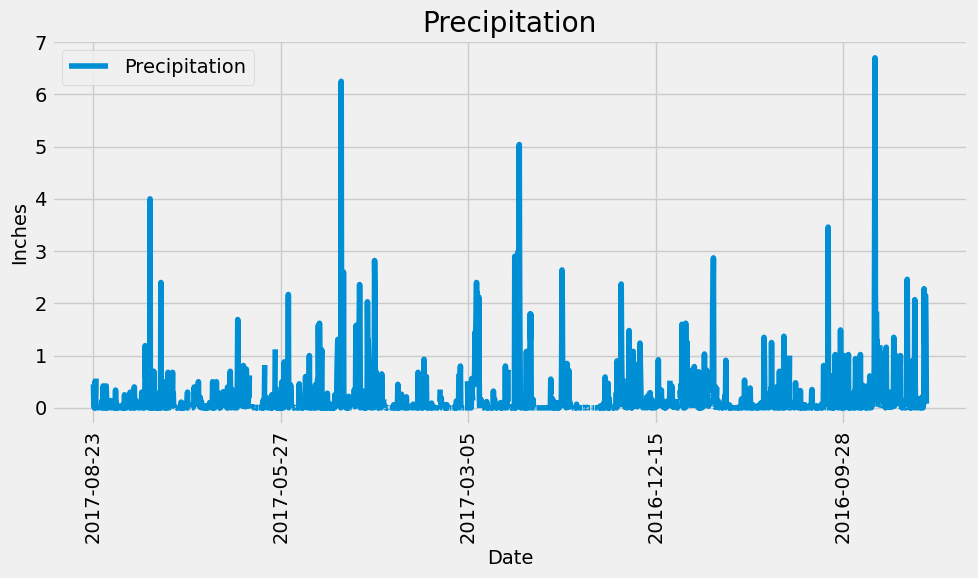

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
most_recent_date_str = most_recent_date[0]
end_date = dt.datetime.strptime(most_recent_date_str, "%Y-%m-%d")
start_date = end_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
df_sorted = df.sort_values(by="Date",ascending=True)


# Use Pandas Plotting with Matplotlib to plot the data
df_sorted.set_index('Date', inplace=True)
df_sorted.plot(figsize=(10, 6), rot=90)  
plt.ylabel('Inches')
plt.xlabel('Date')
plt.title('Precipitation')
plt.tight_layout()
plt.show()

In [11]:
summary_stats = df_sorted['Precipitation'].describe()
print(summary_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [13]:
# Query to determine the most active stations
active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                   .group_by(Measurement.station)
                   .order_by(func.count(Measurement.station).desc())
                   .all())

# Display the results
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

# Query to determine the lowest, highest, and average temperature for the most active station
temperature_stats = (session.query(func.min(Measurement.tobs),
                                   func.max(Measurement.tobs),
                                   func.avg(Measurement.tobs))
                     .filter(Measurement.station == most_active_station)
                     .all())

# Extract the results
results_list = list(temperature_stats[0])

print(results_list)

[54.0, 85.0, 71.66378066378067]


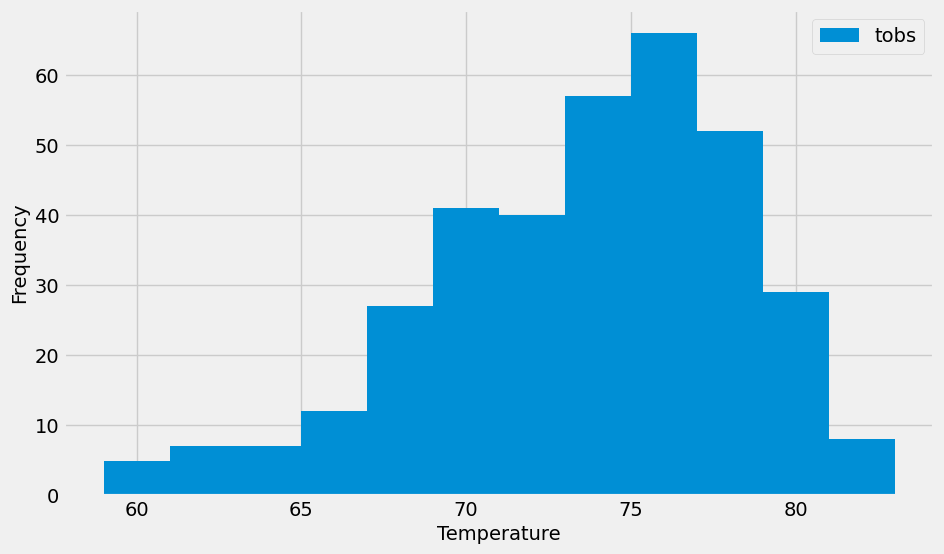

In [16]:
temperature_data = (session.query(Measurement.date, Measurement.tobs)
                    .filter(Measurement.station == most_active_station)
                    .filter(Measurement.date >= start_date)
                    .all())
temp_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])
temp_df['Temperature'].plot(kind='hist', bins=12, figsize=(10,6), label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()

plt.show()





Text(0.5, 4.183333333333314, 'Temperature')

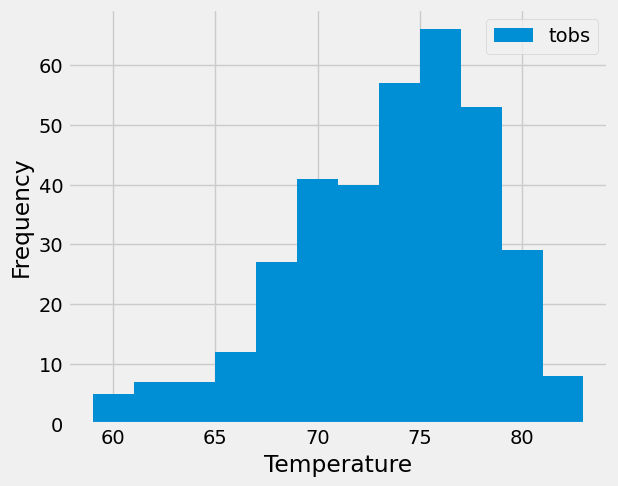

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [17]:
# Close Session
session.close()